In [1]:
%run supervised_functions.ipynb

Calculating probability for start mol sampling


100%|██████████████████████████████████████████████████████████| 69304/69304 [01:30<00:00, 763.58it/s]


In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

### Action dataset

In [3]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rsig_cs_indices", "psub", "pcen", "psig", "psig_cs_indices"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_

# Get top k predictions

In [4]:
import time
def get_topk_predictions(model, source_list, target_list, topk=10):
    # Convert to mols
    if isinstance(source_list, pd.Series):
        source_list = source_list.tolist()
    if isinstance(target_list, pd.Series):
        target_list = target_list.tolist()
    tt = time.time()
    sources = data.Molecule.pack(list(map(molecule_from_smile, source_list)))
    targets = data.Molecule.pack(list(map(molecule_from_smile, target_list)))
    print(f"Took {time.time() - tt}s to pack molecules.")

    # Predictions
    batch_size = 1024
#     pred = model(sources, targets, None, None, "actor").detach()
    pred = torch.concatenate([model(sources[i:min(i+batch_size, sources.batch_size)].to(device), 
                                 targets[i:min(i+batch_size, sources.batch_size)].to(device), None, None, "actor").detach() for i in range(0, sources.batch_size, batch_size)], axis=0)

    action_embeddings = get_action_dataset_embeddings(model.GIN)

    # Get applicable actions for source(s)
    applicable_action_indices_list = []
    
    with Pool(30) as p:
        for idxes in tqdm.tqdm(p.imap(functools.partial(get_emb_indices_and_correct_idx, no_correct_idx=True), 
                                      [{"reactant": source_list[i]} for i in range(pred.shape[0])], chunksize=10),
                              total=pred.shape[0]):
            applicable_action_indices_list.append(idxes)

    # Sort by critic's Q
    dict_of_list_of_indices = {}
    
    for i in tqdm.tqdm(range(pred.shape[0])):
        pred_for_i = pred[i]
        adi = applicable_action_indices_list[i]
        if len(adi) == 0:
            dict_of_list_of_indices[i] = np.array([])
            continue

        # Get top 50 for actor
        dist = torch.linalg.norm(action_embeddings[adi] - pred[i], axis=1)
        dict_of_list_of_indices[i] = adi[torch.argsort(dist)[:50].cpu().numpy().astype(np.int64)]

    # Sort with critic's Q
    i_sorted = list(range(pred.shape[0]))
    action_indices = np.concatenate([dict_of_list_of_indices[i] for i in i_sorted])
    state_indices = np.concatenate([np.full_like(dict_of_list_of_indices[i], i) for i in i_sorted])
    critic_qs = []
    for i in tqdm.tqdm(range(0, action_indices.shape[0], batch_size)):
        batch_reactants = sources[state_indices[i:i+batch_size]]
        batch_products = targets[state_indices[i:i+batch_size]]
        batch_rsigs = action_rsigs[action_indices[i:i+batch_size]]
        batch_psigs = action_psigs[action_indices[i:i+batch_size]]
        critic_qs.append(ac(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device), "critic").detach().cpu().numpy())

    critic_qs = np.concatenate(critic_qs)

    # Get action predictions
    action_pred_indices = []
    start = 0
    for i in tqdm.tqdm(i_sorted):
        end = start + dict_of_list_of_indices[i].shape[0]
        i_critic_qs = critic_qs[start:end]

        action_pred_indices.append(dict_of_list_of_indices[i][i_critic_qs.reshape(-1).argsort()[::-1]][:topk])
        start = end

    return action_pred_indices
    
# %time pred = get_topk_predictions(ac, source_list[:100], target_list[target_list_idx][:100])
# print(len(pred))

In [87]:
def _generate_train_data(smile, steps):
    mol = Chem.MolFromSmiles(smile)

    df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product', 'step'])
    index = []
    
    # Get sequences
    try:
        for i in range(steps):
            actions = get_applicable_actions(mol)
            if actions.shape[0] == 0:
                break

            # Apply a random action
            rand_idx = np.random.randint(0, actions.shape[0])
            product = apply_action(mol, *actions.iloc[rand_idx])

            # Add it to df
            df.loc[df.shape[0], :] = [Chem.MolToSmiles(mol)] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product), i]
            index.append(actions.iloc[rand_idx].name)

            # Next reactant = product
            mol = product
    except Exception as e:
        return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    
    # Fix index
    df.index = index
    
    # Fix target
    df["product"] = Chem.MolToSmiles(product)

    # Fix step
    df['step'] = df.shape[0] - df['step']
    
    return df

def generate_train_data(N, steps, multiprocess=True):
    # Generate dataset
    df_list = []
    final_shape = 0
    smiles_per_random_sample = 300
    pool_chunk_size = 10

    # Create dataset for multi-step pred
    print("Creating dataset...")
    if multiprocess:
        with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
            while final_shape < N:
                smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,), p=categorical_probs_for_sampling_start_mols)

                for new_df in p.imap_unordered(functools.partial(_generate_train_data, steps=steps), smiles, chunksize=10):
                    df_list.append(new_df)
                    final_shape += new_df.shape[0]

                pbar.update(final_shape - pbar.n)
    else:
        raise Exception("Single process not implemented... :'(")

    main_df = pd.concat(df_list)
    return main_df

In [50]:
def apply_actions_on_reactant(args):
    reactant, action_dataset_idx = args
    listy = []
    for idx in action_dataset_idx:
        try:
            listy.append(Chem.MolToSmiles(apply_action(Chem.MolFromSmiles(reactant), *action_dataset.iloc[idx])))
        except Exception as e:
            pass
    return listy

### Generate data

In [92]:
# Get test data
test_data_df = generate_train_data(N=2000, steps=2) # we'll get N/step trajectory samples from this
test_data_df.shape

Creating dataset...


2368it [00:06, 367.82it/s]                                                                            


(2368, 11)

In [93]:
temp_df = test_data_df[test_data_df['step'] == 2]
source_list, target_list = temp_df["reactant"].values, temp_df["product"].values
del temp_df
source_list.shape, target_list.shape

((1168,), (1168,))

### Load model

In [53]:
# Load model
import glob
# file_string = f"models/supervised/actor-critic/*{actor_loss}*steps={steps}*/model.pth"
file_string = f"models/supervised/offlineRL/emb_model_update=1||steps=2||topk=10/model.pth"
ac = torch.load(glob.glob(file_string)[0]).to(device)

### Predictions (trajectories)

In [54]:
target_list_idx = np.arange(target_list.shape[0])

# initialize objects
trajectory_dict = {} # Keeps track of trajectory in dict format (need hash keeys for quick access)
for i in range(len(source_list)):
    trajectory_dict[str(i)] = source_list[i]
source_keys = list(map(str, list(range(len(source_list))))) # Map for index to keys of previous step in trajectory

# RUN -----------------------
for i_step in range(1, 4): 
    print("Running prediction for step", i_step)
    # Get action predictions
    %time pred = get_topk_predictions(ac, source_list, target_list[target_list_idx])

    # get products
    temp_source_keys = []
    temp_source_list = []
    with Pool(30) as p:
        print("Applying actions for step", i_step)
        for i, product_list in tqdm.tqdm(enumerate(p.imap(apply_actions_on_reactant, zip(source_list, pred), chunksize=10)), total=len(pred)):
            for _i, product in enumerate(product_list):
                key = f"{source_keys[i]}_{_i}"
                trajectory_dict[key] = product
                temp_source_keys.append(key)
                temp_source_list.append(product)
                
    # update source list and source_keys for next step
    source_list = temp_source_list
    source_keys = temp_source_keys
    target_list_idx = list(map(lambda x: int(x.split("_")[0]), source_keys))

Running prediction for step 1


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)


Took 5.554426670074463s to pack molecules.


100%|█████████████████████████████████████████████████████████| 1928/1928 [00:00<00:00, 120059.66it/s]

CPU times: user 5min 49s, sys: 27.8 s, total: 6min 17s
Wall time: 34.2 s


Applying actions for step 1


100%|████████████████████████████████████████████████████████████| 1928/1928 [00:04<00:00, 471.45it/s]


Running prediction for step 2
Took 64.96120142936707s to pack molecules.


100%|███████████████████████████████████████████████████████| 19256/19256 [00:00<00:00, 129477.78it/s]


CPU times: user 38min 55s, sys: 2min 26s, total: 41min 22s
Wall time: 3min 57s
Applying actions for step 2


100%|██████████████████████████████████████████████████████████| 19256/19256 [00:51<00:00, 375.90it/s]


Running prediction for step 3


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `As`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)


Took 651.6760439872742s to pack molecules.


100%|█████████████████████████████████████████████████████| 179538/179538 [00:00<00:00, 202694.92it/s]


CPU times: user 5h 57min 43s, sys: 20min 41s, total: 6h 18min 24s
Wall time: 37min 20s
Applying actions for step 3


100%|████████████████████████████████████████████████████████| 179538/179538 [08:39<00:00, 345.35it/s]


# Analysis

In [55]:
all_keys = np.array(list(trajectory_dict.keys()))
# GED_dict = {}
sim_dict = {}

def my_convenient_similarity_fn(s1, m2):
    return similarity(Chem.MolFromSmiles(s1), m2)

with Pool(30) as p:
    for i in tqdm.tqdm(range(target_list.shape[0])):
        target_mol = Chem.MolFromSmiles(target_list[i])
        
        # Do it for the source mol
        sim_dict[str(i)] = my_convenient_similarity_fn(trajectory_dict[str(i)], target_mol)
        
        # Get for others
        key_for_i = list(filter(lambda x: x.startswith(str(i)+'_'), all_keys))
        for _i, sim in enumerate(p.imap(functools.partial(my_convenient_similarity_fn, m2=target_mol), np.vectorize(trajectory_dict.get)(key_for_i))):
            sim_dict[key_for_i[_i]] = sim

100%|█████████████████████████████████████████████████████████████| 1928/1928 [41:02<00:00,  1.28s/it]


######################################################################################################################################################
941
source


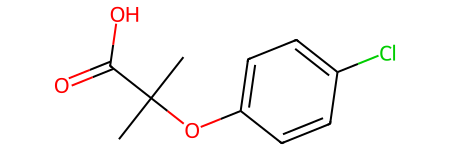

target


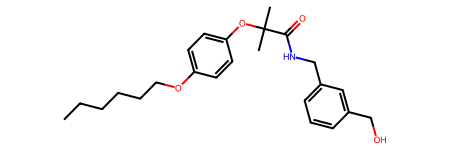

sim = 1: 1 | sim >= 0.9: 1 | sim >= 0.8: 1
--------------------------------------------------
Steps for highest sim = 1.00
Sim = 0.29


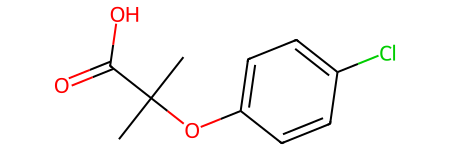

Sim = 0.66


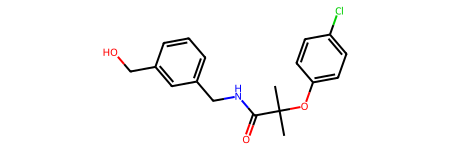

Sim = 1.00


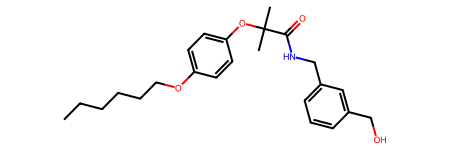

######################################################################################################################################################
795
source


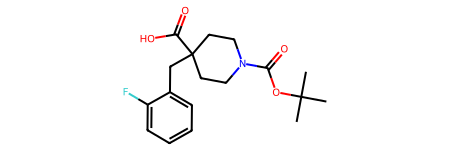

target


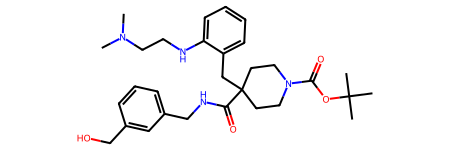

sim = 1: 1 | sim >= 0.9: 1 | sim >= 0.8: 3
--------------------------------------------------
Steps for highest sim = 1.00
Sim = 0.47


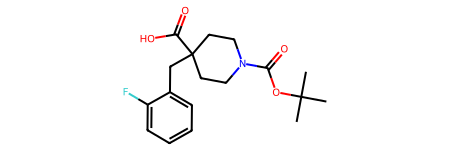

Sim = 0.77


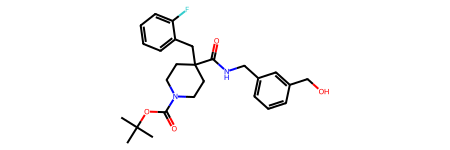

Sim = 1.00


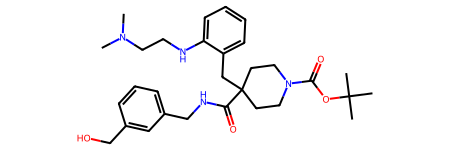

######################################################################################################################################################
842
source


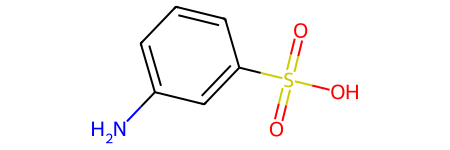

target


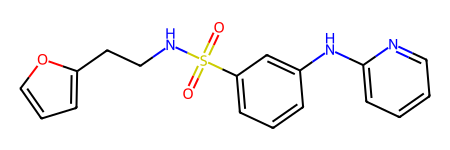

sim = 1: 0 | sim >= 0.9: 0 | sim >= 0.8: 0
--------------------------------------------------
Steps for highest sim = 0.78
Sim = 0.22


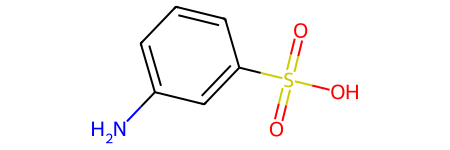

Sim = 0.43


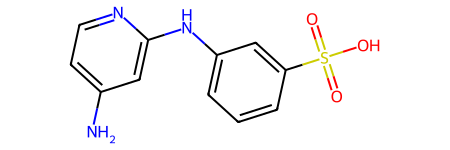

Sim = 0.78


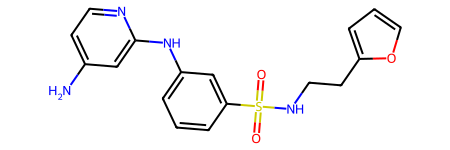

######################################################################################################################################################
379
source


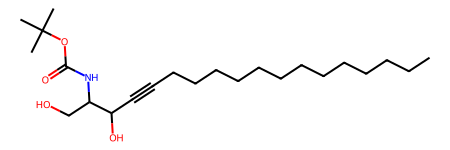

target


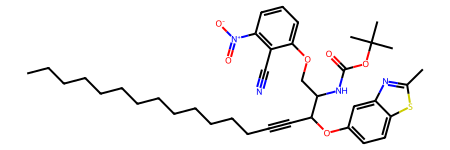

sim = 1: 1 | sim >= 0.9: 1 | sim >= 0.8: 27
--------------------------------------------------
Steps for highest sim = 1.00
Sim = 0.45


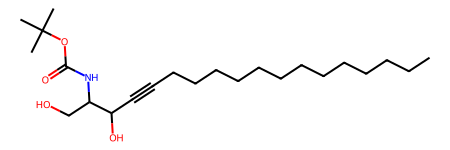

Sim = 0.71


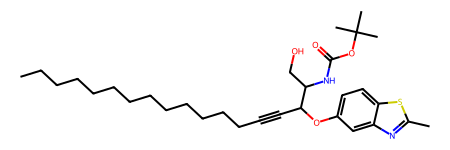

Sim = 1.00


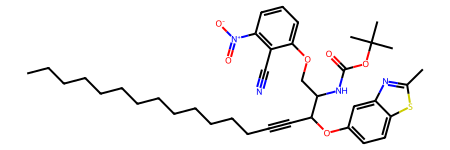

######################################################################################################################################################
248
source


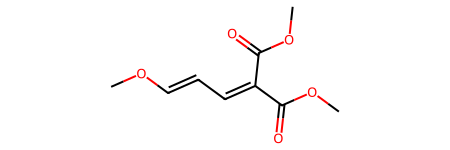

target


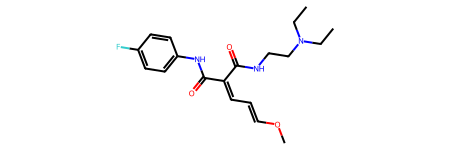

sim = 1: 0 | sim >= 0.9: 0 | sim >= 0.8: 0
--------------------------------------------------
Steps for highest sim = 0.73
Sim = 0.28


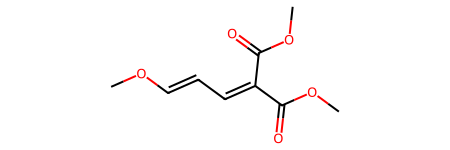

Sim = 0.57


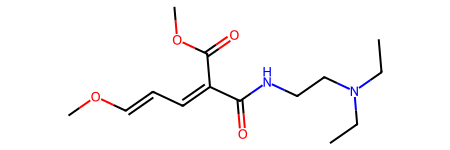

Sim = 0.73


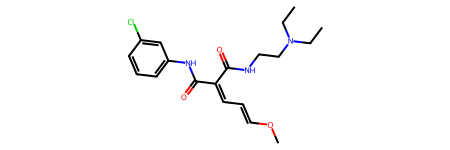

In [56]:
rand_idx = np.random.randint(0, 1000, (5,))

for r in rand_idx:
    print("#"*150)
    print(r)
    print("source")
    display(Chem.MolFromSmiles(trajectory_dict[str(r)]))
    print("target")
    display(Chem.MolFromSmiles(target_list[r]))
    
    keys_for_r = np.array(list(filter(lambda x: x.startswith(str(r)+'_'), all_keys)))
    sim_for_r = np.vectorize(sim_dict.get)(keys_for_r)
    
    print(f"sim = 1: {(sim_for_r == 1).sum()} | sim >= 0.9: {(sim_for_r >= 0.9).sum()} | sim >= 0.8: {(sim_for_r >= 0.8).sum()}")
    
    print("-"*50)
    print(f"Steps for highest sim = {sim_for_r.max():.2f}")
    key = keys_for_r[(sim_for_r == sim_for_r.max())][0]
    
    traj_idxes = key.split('_')
    for i in range(1, len(traj_idxes)+1):
        key = "_".join(traj_idxes[:i])
        print(f"Sim = {sim_dict[key]:.2f}")
        display(Chem.MolFromSmiles(trajectory_dict[key]))

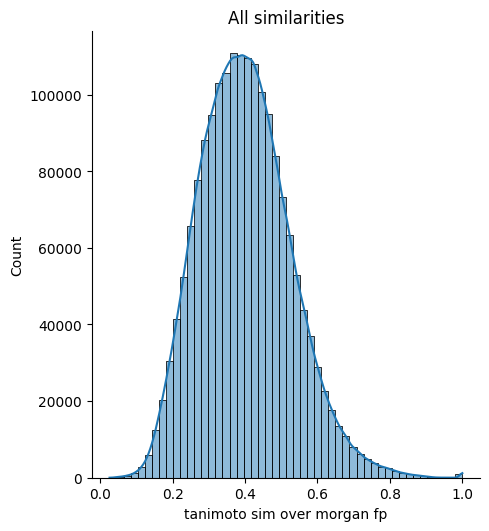

In [57]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

sim_vals = np.array(list(sim_dict.values()))
sns.displot(sim_vals, kde=True, bins=50)
plt.title("All similarities")
plt.xlabel("tanimoto sim over morgan fp")
plt.show()

In [58]:
stepwise_keys = {}
for step in range(0, 4):
    stepwise_keys[step] = set(list(filter(lambda x: len(x.split('_')) == step+1, all_keys)))
    

source_index_wise_keys = {}
for i in tqdm.tqdm(range(len(target_list))):
    source_index_wise_keys[i] = set(list(filter(lambda x: x == str(i) or x.startswith(str(i)+'_'), all_keys)))

100%|█████████████████████████████████████████████████████████████| 1928/1928 [42:58<00:00,  1.34s/it]


In [68]:
best_sim_list = []
step_for_best_sim_list = []

for i in tqdm.tqdm(range(len(target_list))):
    keys_for_i = list(filter(lambda x: len(x.split("_")) > 1, list(source_index_wise_keys[i])))
    sim_list_for_i = np.vectorize(sim_dict.get)(keys_for_i)
    
    best_arg = sim_list_for_i.argmax()
    best_sim_list.append(sim_list_for_i[best_arg])
    step_for_best_sim_list.append(len(keys_for_i[best_arg].split("_"))-1)

best_sim_list = np.array(best_sim_list)
step_for_best_sim_list = np.array(step_for_best_sim_list)
print(f"Average best sim = {np.mean(best_sim_list)}")
print(f"% correct paths predicted = {(best_sim_list==1).sum()/best_sim_list.shape[0]*100}")
print(f"Average path length for best sim = {np.mean(step_for_best_sim_list)}")

100%|███████████████████████████████████████████████████████████| 1928/1928 [00:01<00:00, 1054.28it/s]

Average best sim = 0.8112332725049874
% correct paths predicted = 37.60373443983403
Average path length for best sim = 2.194502074688797


The above value is differerent from p*\*n that could be expected from the results sheet  
\- step 2: %rank<=10 = 75%  
So we may expect 75% correct for step 1 and 75% correct for step 2 => (0.75 * 0.75) ~= 56% correct trajectories.  
But after step 1, the wrong 25% no longer have 75% accuracy for next step => (0.75 * x) ~= 37.6%  || Solving gives 50%

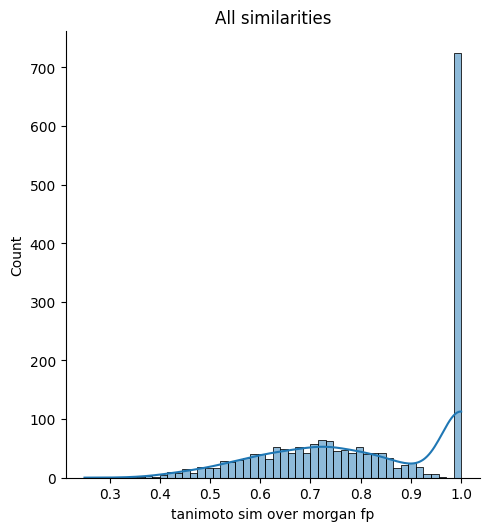

In [69]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

sns.displot(best_sim_list, kde=True, bins=50)
plt.title("All similarities")
plt.xlabel("tanimoto sim over morgan fp")
plt.show()

/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  


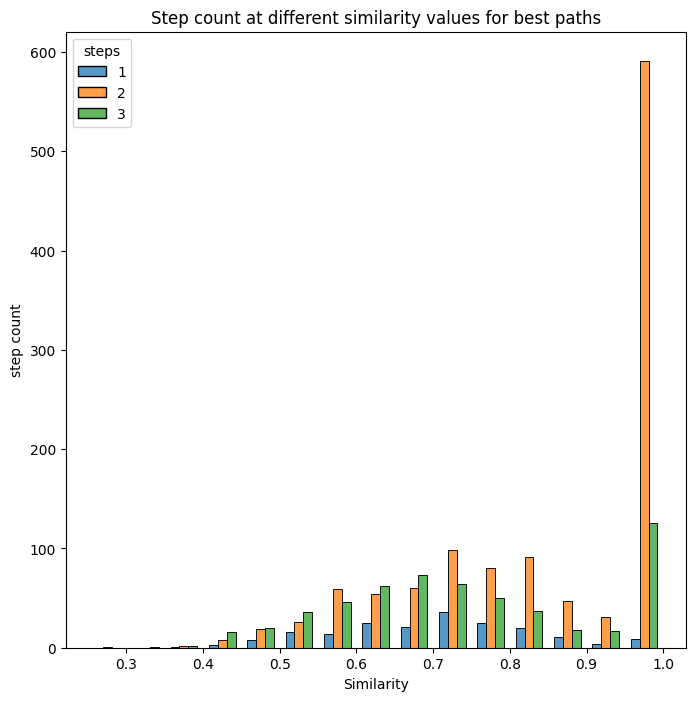

In [73]:
plt.figure(figsize=(8, 8))
sns.histplot(pd.DataFrame({"steps": step_for_best_sim_list, "sim": best_sim_list}), x="sim", hue='steps', multiple='dodge', shrink=0.7, palette=sns.color_palette())
plt.ylabel("step count")
plt.xlabel("Similarity")
plt.title("Step count at different similarity values for best paths")
plt.show()

### There are 2 step paths that were completed in 1 step!? (sim = 1 & step = 1)
It found shorter paths!!!!!

There are (9,) such indices.
######################################################################################################################################################
63
Actual


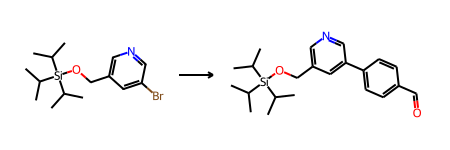

######################################################################################################################################################
70
Actual


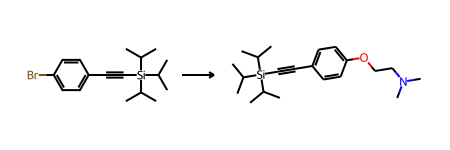

######################################################################################################################################################
82
Actual


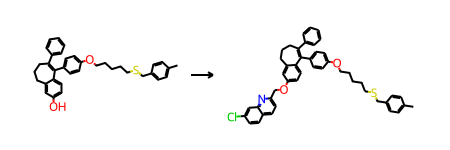

######################################################################################################################################################
114
Actual


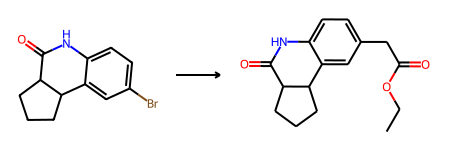

######################################################################################################################################################
139
Actual


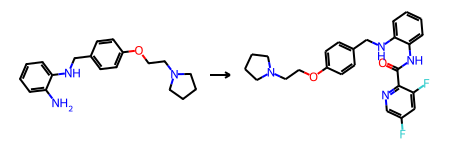

######################################################################################################################################################
422
Actual


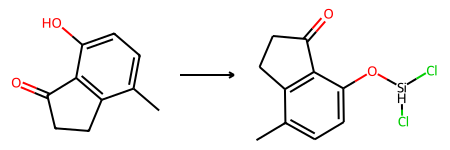

######################################################################################################################################################
1168
Actual


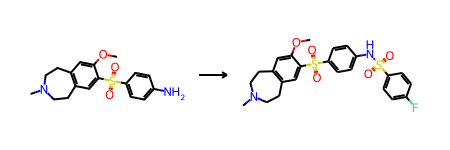

######################################################################################################################################################
1656
Actual


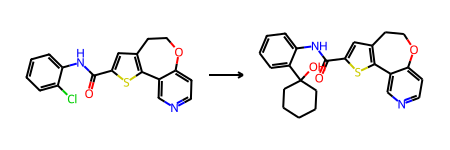

######################################################################################################################################################
1815
Actual


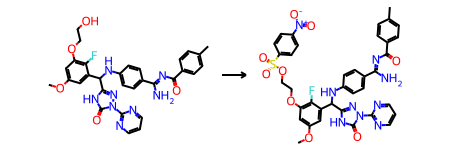

In [76]:
indices = np.where((best_sim_list == 1) & (step_for_best_sim_list == 1))[0]
print(f"There are {indices.shape} such indices.")

for i in indices:
    print("#"*150)
    print(i)
    print("Actual")
    
#     display(Chem.AllChem.ReactionFromSmarts(f"{trajectory_dict[str(i)]}>>{target_list[i]}", useSmiles=True))
#     display(Chem.MolFromSmiles(trajectory_dict[str(r)]))
#     print("target")
#     display(Chem.MolFromSmiles(target_list[r]))
    
#     keys_for_r = np.array(list(filter(lambda x: x.startswith(str(r)+'_'), all_keys)))
#     sim_for_r = np.vectorize(sim_dict.get)(keys_for_r)
    
#     print(f"sim = 1: {(sim_for_r == 1).sum()} | sim >= 0.9: {(sim_for_r >= 0.9).sum()} | sim >= 0.8: {(sim_for_r >= 0.8).sum()}")
    
#     print("-"*50)
#     print(f"Steps for highest sim = {sim_for_r.max():.2f}")
#     key = keys_for_r[(sim_for_r == sim_for_r.max())][0]
    
#     traj_idxes = key.split('_')
#     for i in range(1, len(traj_idxes)+1):
#         key = "_".join(traj_idxes[:i])
#         print(f"Sim = {sim_dict[key]:.2f}")
#         display(Chem.MolFromSmiles(trajectory_dict[key]))

# Trying to figure out a way to limit branching

In [112]:
for key in stepwise_keys.keys():
    if key == 0:
        continue
    print("Step =", key) 
    temp_sim = np.vectorize(sim_dict.get)(list(stepwise_keys[key]))
    print(f"Overall: min={temp_sim.min():.2f} || max={temp_sim.max():.2f} || mean={temp_sim.mean():.2f}")
    
    temp_sim = best_sim_list[step_for_best_sim_list == key]
    print(f"Best:    min={temp_sim.min():.2f} || max={temp_sim.max():.2f} || mean={temp_sim.mean():.2f}")
    print()

Step = 1
Overall: min=0.08 || max=1.00 || mean=0.47
Best:    min=0.40 || max=1.00 || mean=0.70

Step = 2
Overall: min=0.04 || max=1.00 || mean=0.44
Best:    min=0.25 || max=1.00 || mean=0.86

Step = 3
Overall: min=0.03 || max=1.00 || mean=0.39
Best:    min=0.34 || max=1.00 || mean=0.75



In [145]:
for i in list(source_index_wise_keys.keys()):
    print("Source target idx =", i)
    keys_for_i = list(filter(lambda x: len(x.split("_")) > 1, list(source_index_wise_keys[i])))
    sim_list_for_i = np.vectorize(sim_dict.get)(keys_for_i)
    best_arg = sim_list_for_i.argmax()
    best_key = keys_for_i[best_arg]
    best_path_idx = best_key.split("_")
    best_path_sim = [sim_dict["_".join(best_path_idx[:_i+1])] for _i in range(len(best_path_idx))]
    print("Best path sim", " --> ".join([f"{sim:.2f}" for sim in best_path_sim]))
    
    average_path_sim = [best_path_sim[0]]
    order_of_best_sim = [1]
    total_order_of_best_sim = [1]
    for _i in range(1, len(best_path_sim)):
        sim = np.vectorize(sim_dict.get)(list(source_index_wise_keys[i].intersection(stepwise_keys[_i])))
        sim = np.sort(sim)[::-1]
        order_of_best_sim.append(np.where(sim == best_path_sim[_i])[0][0] + 1)
        total_order_of_best_sim.append(sim.shape[0])
        sim = sim.mean()
        average_path_sim.append(sim)
    print("Average path sim = ", " --> ".join([f"{sim:.2f}" for sim in average_path_sim]))
    print("Order of best sim  =", " --> ".join([f"{o}/{t}" for o, t in zip(order_of_best_sim, total_order_of_best_sim)]))
    print()

Source target idx = 0
Best path sim 0.34 --> 0.67 --> 1.00
Average path sim =  0.34 --> 0.44 --> 0.41
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1
Best path sim 0.45 --> 0.45 --> 0.66
Average path sim =  0.45 --> 0.44 --> 0.43
Order of best sim  = 1/1 --> 5/10 --> 1/100

Source target idx = 2
Best path sim 0.44 --> 0.65 --> 0.64 --> 1.00
Average path sim =  0.44 --> 0.54 --> 0.59 --> 0.55
Order of best sim  = 1/1 --> 1/10 --> 20/91 --> 1/798

Source target idx = 3
Best path sim 0.26 --> 0.74 --> 1.00
Average path sim =  0.26 --> 0.40 --> 0.39
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 4
Best path sim 0.34 --> 0.77 --> 1.00
Average path sim =  0.34 --> 0.47 --> 0.41
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 5
Best path sim 0.52 --> 0.40 --> 0.52 --> 0.54
Average path sim =  0.52 --> 0.43 --> 0.36 --> 0.33
Order of best sim  = 1/1 --> 9/10 --> 2/54 --> 1/259

Source target idx = 6
Best path sim 0.27 --> 0.68 --> 1.00
Aver

Average path sim =  0.28 --> 0.41 --> 0.41
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 132
Best path sim 0.49 --> 0.56 --> 0.71
Average path sim =  0.49 --> 0.52 --> 0.50
Order of best sim  = 1/1 --> 4/10 --> 1/100

Source target idx = 133
Best path sim 0.25 --> 0.33 --> 0.64
Average path sim =  0.25 --> 0.34 --> 0.39
Order of best sim  = 1/1 --> 6/10 --> 1/100

Source target idx = 134
Best path sim 0.49 --> 0.72 --> 1.00
Average path sim =  0.49 --> 0.54 --> 0.64
Order of best sim  = 1/1 --> 1/10 --> 1/30

Source target idx = 135
Best path sim 0.28 --> 0.28 --> 0.45
Average path sim =  0.28 --> 0.25 --> 0.24
Order of best sim  = 1/1 --> 2/10 --> 1/100

Source target idx = 136
Best path sim 0.23 --> 0.49 --> 0.83
Average path sim =  0.23 --> 0.37 --> 0.42
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 137
Best path sim 0.44 --> 0.76 --> 1.00
Average path sim =  0.44 --> 0.57 --> 0.48
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx =

Average path sim =  0.55 --> 0.62 --> 0.60 --> 0.55
Order of best sim  = 1/1 --> 3/10 --> 5/100 --> 1/1000

Source target idx = 271
Best path sim 0.43 --> 0.74 --> 0.81 --> 1.00
Average path sim =  0.43 --> 0.50 --> 0.50 --> 0.46
Order of best sim  = 1/1 --> 1/10 --> 3/99 --> 1/984

Source target idx = 272
Best path sim 0.45 --> 0.54 --> 0.53 --> 0.63
Average path sim =  0.45 --> 0.46 --> 0.45 --> 0.43
Order of best sim  = 1/1 --> 1/10 --> 4/100 --> 1/815

Source target idx = 273
Best path sim 0.46 --> 0.50 --> 0.65 --> 0.69
Average path sim =  0.46 --> 0.49 --> 0.50 --> 0.45
Order of best sim  = 1/1 --> 4/10 --> 3/100 --> 1/874

Source target idx = 274
Best path sim 0.29 --> 0.62 --> 1.00
Average path sim =  0.29 --> 0.34 --> 0.35
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 275
Best path sim 0.64 --> 0.69 --> 0.88
Average path sim =  0.64 --> 0.62 --> 0.60
Order of best sim  = 1/1 --> 2/10 --> 1/100

Source target idx = 276
Best path sim 0.25 --> 0.49 --> 0.49 -->

Average path sim =  0.35 --> 0.56 --> 0.56
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 418
Best path sim 0.24 --> 0.66 --> 1.00
Average path sim =  0.24 --> 0.40 --> 0.43
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 419
Best path sim 0.39 --> 0.72 --> 1.00
Average path sim =  0.39 --> 0.45 --> 0.46
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 420
Best path sim 0.27 --> 0.50 --> 0.56
Average path sim =  0.27 --> 0.36 --> 0.33
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 421
Best path sim 0.33 --> 0.52 --> 0.64
Average path sim =  0.33 --> 0.45 --> 0.35
Order of best sim  = 1/1 --> 3/10 --> 1/88

Source target idx = 422
Best path sim 0.57 --> 1.00
Average path sim =  0.57 --> 0.46
Order of best sim  = 1/1 --> 1/10

Source target idx = 423
Best path sim 0.45 --> 0.70 --> 1.00
Average path sim =  0.45 --> 0.52 --> 0.51
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 424
Best path sim 0.50 --> 

Best path sim 0.39 --> 0.72 --> 1.00 --> 1.00
Average path sim =  0.39 --> 0.54 --> 0.54 --> 0.52
Order of best sim  = 1/1 --> 1/10 --> 1/75 --> 1/641

Source target idx = 561
Best path sim 0.34 --> 0.76 --> 0.89
Average path sim =  0.34 --> 0.41 --> 0.44
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 562
Best path sim 0.55 --> 0.64 --> 0.85
Average path sim =  0.55 --> 0.59 --> 0.61
Order of best sim  = 1/1 --> 2/10 --> 1/100

Source target idx = 563
Best path sim 0.43 --> 0.66
Average path sim =  0.43 --> 0.52
Order of best sim  = 1/1 --> 1/10

Source target idx = 564
Best path sim 0.32 --> 0.67 --> 1.00
Average path sim =  0.32 --> 0.40 --> 0.39
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 565
Best path sim 0.36 --> 0.79 --> 1.00
Average path sim =  0.36 --> 0.51 --> 0.44
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 566
Best path sim 0.45 --> 0.49 --> 0.80
Average path sim =  0.45 --> 0.49 --> 0.54
Order of best sim  = 1/1 --

Average path sim =  0.35 --> 0.48 --> 0.52
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 706
Best path sim 0.44 --> 0.53 --> 0.63
Average path sim =  0.44 --> 0.55 --> 0.51
Order of best sim  = 1/1 --> 8/10 --> 1/100

Source target idx = 707
Best path sim 0.47 --> 0.66 --> 1.00
Average path sim =  0.47 --> 0.54 --> 0.60
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 708
Best path sim 0.60 --> 0.60 --> 0.72 --> 1.00
Average path sim =  0.60 --> 0.60 --> 0.60 --> 0.56
Order of best sim  = 1/1 --> 4/10 --> 13/100 --> 1/1000

Source target idx = 709
Best path sim 0.28 --> 0.44 --> 0.71 --> 0.84
Average path sim =  0.28 --> 0.39 --> 0.41 --> 0.36
Order of best sim  = 1/1 --> 1/10 --> 1/100 --> 1/1000

Source target idx = 710
Best path sim 0.41 --> 0.53 --> 1.00
Average path sim =  0.41 --> 0.40 --> 0.40
Order of best sim  = 1/1 --> 1/10 --> 1/86

Source target idx = 711
Best path sim 0.29 --> 0.42 --> 0.56
Average path sim =  0.29 --> 0.31 --> 0.31
Order

Average path sim =  0.30 --> 0.32 --> 0.32 --> 0.30
Order of best sim  = 1/1 --> 1/10 --> 1/100 --> 1/980

Source target idx = 852
Best path sim 0.43 --> 0.69 --> 0.84
Average path sim =  0.43 --> 0.55 --> 0.52
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 853
Best path sim 0.45 --> 0.82 --> 0.92
Average path sim =  0.45 --> 0.54 --> 0.53
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 854
Best path sim 0.37 --> 0.89 --> 1.00
Average path sim =  0.37 --> 0.51 --> 0.48
Order of best sim  = 1/1 --> 1/10 --> 1/51

Source target idx = 855
Best path sim 0.34 --> 0.64 --> 1.00
Average path sim =  0.34 --> 0.50 --> 0.47
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 856
Best path sim 0.44 --> 0.82 --> 1.00
Average path sim =  0.44 --> 0.47 --> 0.49
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 857
Best path sim 0.75 --> 0.87 --> 0.88 --> 0.90
Average path sim =  0.75 --> 0.74 --> 0.70 --> 0.66
Order of best sim  = 1/1 --

Average path sim =  0.26 --> 0.44 --> 0.41 --> 0.38
Order of best sim  = 1/1 --> 4/10 --> 5/100 --> 1/991

Source target idx = 997
Best path sim 0.50 --> 0.73 --> 1.00
Average path sim =  0.50 --> 0.55 --> 0.46
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 998
Best path sim 0.31 --> 0.33 --> 0.34 --> 0.58
Average path sim =  0.31 --> 0.29 --> 0.25 --> 0.21
Order of best sim  = 1/1 --> 2/10 --> 5/100 --> 1/992

Source target idx = 999
Best path sim 0.34 --> 0.66 --> 0.75
Average path sim =  0.34 --> 0.45 --> 0.45
Order of best sim  = 1/1 --> 1/10 --> 1/70

Source target idx = 1000
Best path sim 0.68 --> 0.68
Average path sim =  0.68 --> 0.46
Order of best sim  = 1/1 --> 1/10

Source target idx = 1001
Best path sim 0.56 --> 0.71 --> 0.80
Average path sim =  0.56 --> 0.55 --> 0.53
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1002
Best path sim 0.54 --> 0.81 --> 0.85 --> 0.85
Average path sim =  0.54 --> 0.60 --> 0.53 --> 0.50
Order of best sim  = 1/1

Average path sim =  0.33 --> 0.43 --> 0.37
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1131
Best path sim 0.34 --> 0.37 --> 0.59 --> 0.63
Average path sim =  0.34 --> 0.34 --> 0.35 --> 0.33
Order of best sim  = 1/1 --> 4/10 --> 1/100 --> 1/996

Source target idx = 1132
Best path sim 0.36 --> 0.33 --> 0.47 --> 0.56
Average path sim =  0.36 --> 0.31 --> 0.38 --> 0.35
Order of best sim  = 1/1 --> 3/10 --> 6/100 --> 1/755

Source target idx = 1133
Best path sim 0.51 --> 0.80 --> 1.00
Average path sim =  0.51 --> 0.62 --> 0.63
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1134
Best path sim 0.34 --> 0.69 --> 1.00
Average path sim =  0.34 --> 0.41 --> 0.39
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1135
Best path sim 0.32 --> 0.69 --> 0.82
Average path sim =  0.32 --> 0.52 --> 0.52
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1136
Best path sim 0.26 --> 0.68 --> 1.00
Average path sim =  0.26 --> 0.38 --> 0.39
O

Average path sim =  0.33 --> 0.30 --> 0.30 --> 0.30
Order of best sim  = 1/1 --> 1/10 --> 1/100 --> 1/636

Source target idx = 1267
Best path sim 0.15 --> 0.14 --> 0.63
Average path sim =  0.15 --> 0.17 --> 0.22
Order of best sim  = 1/1 --> 9/10 --> 1/64

Source target idx = 1268
Best path sim 0.56 --> 0.88 --> 1.00
Average path sim =  0.56 --> 0.65 --> 0.59
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1269
Best path sim 0.72 --> 1.00 --> 1.00
Average path sim =  0.72 --> 0.60 --> 0.37
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1270
Best path sim 0.39 --> 0.51 --> 0.67
Average path sim =  0.39 --> 0.49 --> 0.44
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1271
Best path sim 0.30 --> 0.71 --> 1.00
Average path sim =  0.30 --> 0.42 --> 0.41
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1272
Best path sim 0.36 --> 0.50 --> 0.47 --> 0.61
Average path sim =  0.36 --> 0.50 --> 0.46 --> 0.44
Order of best sim  = 

Average path sim =  0.42 --> 0.52 --> 0.49
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1403
Best path sim 0.52 --> 0.88 --> 0.92
Average path sim =  0.52 --> 0.64 --> 0.65
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1404
Best path sim 0.47 --> 0.61 --> 0.73
Average path sim =  0.47 --> 0.53 --> 0.52
Order of best sim  = 1/1 --> 1/10 --> 1/95

Source target idx = 1405
Best path sim 0.60 --> 0.59 --> 0.59 --> 0.70
Average path sim =  0.60 --> 0.55 --> 0.48 --> 0.43
Order of best sim  = 1/1 --> 4/10 --> 9/100 --> 1/990

Source target idx = 1406
Best path sim 0.50 --> 0.63 --> 0.66 --> 0.79
Average path sim =  0.50 --> 0.53 --> 0.52 --> 0.47
Order of best sim  = 1/1 --> 2/10 --> 5/100 --> 1/924

Source target idx = 1407
Best path sim 0.30 --> 0.67 --> 1.00
Average path sim =  0.30 --> 0.45 --> 0.41
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1408
Best path sim 0.48 --> 0.73 --> 1.00
Average path sim =  0.48 --> 0.56 --> 0.60
Or

Average path sim =  0.60 --> 0.49 --> 0.43
Order of best sim  = 1/1 --> 2/10 --> 1/100

Source target idx = 1544
Best path sim 0.17 --> 0.69
Average path sim =  0.17 --> 0.35
Order of best sim  = 1/1 --> 1/10

Source target idx = 1545
Best path sim 0.56 --> 0.64 --> 0.75 --> 0.75
Average path sim =  0.56 --> 0.60 --> 0.57 --> 0.49
Order of best sim  = 1/1 --> 1/10 --> 1/55 --> 1/342

Source target idx = 1546
Best path sim 0.15 --> 0.79 --> 0.79 --> 0.89
Average path sim =  0.15 --> 0.34 --> 0.34 --> 0.34
Order of best sim  = 1/1 --> 1/10 --> 3/100 --> 1/850

Source target idx = 1547
Best path sim 0.39 --> 0.51 --> 0.62
Average path sim =  0.39 --> 0.45 --> 0.47
Order of best sim  = 1/1 --> 2/10 --> 1/100

Source target idx = 1548
Best path sim 0.42 --> 0.61 --> 0.71 --> 0.71
Average path sim =  0.42 --> 0.49 --> 0.47 --> 0.44
Order of best sim  = 1/1 --> 1/10 --> 1/100 --> 1/932

Source target idx = 1549
Best path sim 0.22 --> 0.73 --> 1.00
Average path sim =  0.22 --> 0.29 --> 0.23
Or

Average path sim =  0.41 --> 0.38 --> 0.34 --> 0.32
Order of best sim  = 1/1 --> 1/10 --> 1/100 --> 1/754

Source target idx = 1680
Best path sim 0.47 --> 0.78 --> 0.86
Average path sim =  0.47 --> 0.53 --> 0.52
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1681
Best path sim 0.62 --> 0.90 --> 1.00
Average path sim =  0.62 --> 0.64 --> 0.61
Order of best sim  = 1/1 --> 1/10 --> 1/63

Source target idx = 1682
Best path sim 0.30 --> 0.77 --> 1.00
Average path sim =  0.30 --> 0.40 --> 0.37
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1683
Best path sim 0.38 --> 0.54 --> 0.69
Average path sim =  0.38 --> 0.49 --> 0.47
Order of best sim  = 1/1 --> 2/10 --> 1/100

Source target idx = 1684
Best path sim 0.55 --> 0.76 --> 1.00
Average path sim =  0.55 --> 0.53 --> 0.50
Order of best sim  = 1/1 --> 1/10 --> 1/62

Source target idx = 1685
Best path sim 0.39 --> 0.84 --> 0.80 --> 0.87
Average path sim =  0.39 --> 0.42 --> 0.40 --> 0.38
Order of best sim  = 1

Average path sim =  0.34 --> 0.43 --> 0.37 --> 0.34
Order of best sim  = 1/1 --> 10/10 --> 1/100 --> 1/983

Source target idx = 1823
Best path sim 0.26 --> 0.55 --> 1.00
Average path sim =  0.26 --> 0.38 --> 0.44
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1824
Best path sim 0.43 --> 0.72 --> 0.79
Average path sim =  0.43 --> 0.49 --> 0.49
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1825
Best path sim 0.27 --> 0.45 --> 0.44 --> 0.68
Average path sim =  0.27 --> 0.44 --> 0.42 --> 0.40
Order of best sim  = 1/1 --> 5/10 --> 27/63 --> 1/330

Source target idx = 1826
Best path sim 0.32 --> 0.65 --> 1.00
Average path sim =  0.32 --> 0.45 --> 0.35
Order of best sim  = 1/1 --> 1/10 --> 1/100

Source target idx = 1827
Best path sim 0.28 --> 0.39 --> 0.38 --> 0.51
Average path sim =  0.28 --> 0.31 --> 0.30 --> 0.27
Order of best sim  = 1/1 --> 1/10 --> 15/100 --> 1/1000

Source target idx = 1828
Best path sim 0.22 --> 0.72 --> 1.00
Average path sim =  0.